In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../src/')

In [3]:
# set plotting params
import matplotlib as mpl
import plots
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.reload_library()
rcparams = plots.stdrcparams()
mpl.rcParams.update(rcparams)

from preprocess import *

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [5]:
from tableone import TableOne

In [6]:
carpediem_dir = r'../data/carpediem'
curated_dir = r'../data/curated'
mimic_dir = r'../data/mimiciv_included'

## carpediem

In [7]:
data = pd.read_csv(os.path.join(carpediem_dir, '02data-external_dc_240314_1915.csv'), index_col=0)

In [8]:
pat_cols = [
    'Patient_id', 'Number_of_ICU_stays', 'Patient_category', 'Discharge_disposition', 
    'Age', 'Gender',
    'Race', 'Admit_SOFA_score'
]

In [9]:
carpediem = data[pat_cols].drop_duplicates()

In [10]:
carpediem = carpediem.merge(data.groupby('Patient_id').size().to_frame('Number_of_ICU_days').reset_index())

In [11]:
carpediem = carpediem.assign(Discharge='Other')
carpediem.loc[carpediem.Discharge_disposition.isna(), 'Discharge'] = np.nan
carpediem.loc[carpediem.Discharge_disposition=='Home', 'Discharge'] = 'Home'
carpediem.loc[carpediem.Discharge_disposition=='Died', 'Discharge'] = 'Died'

In [12]:
carpediem.drop(columns=['Discharge_disposition'], inplace=True)

## mimic

In [13]:
mimic_raw_dir = r'../data/mimic_iv'
mimic_dr_dir = r'../data/mimiciv_derived'

In [14]:
data = pd.read_csv(os.path.join(mimic_dir, 'data.csv'), index_col=0)

In [15]:
admissions = pd.read_csv(os.path.join(mimic_raw_dir, 'hosp', 'admissions.csv.gz'))

In [16]:
patients = pd.read_csv(os.path.join(mimic_raw_dir, 'hosp', 'patients.csv.gz'))

In [17]:
mimic = data[['hadm_id', 'icustay_seq']].drop_duplicates().groupby('hadm_id').size().to_frame('Number_of_ICU_stays').reset_index()

In [18]:
mimic = mimic.merge(admissions[['hadm_id', 'discharge_location', 'race']].drop_duplicates(), how='left', on='hadm_id')

In [19]:
mimic = mimic.merge(data.groupby('hadm_id').size().to_frame('Number_of_ICU_days').reset_index())

In [20]:
mimic = mimic.assign(Discharge='Other')
mimic.loc[mimic.discharge_location.isna(), 'Discharge'] = np.nan
mimic.loc[mimic.discharge_location=='HOME', 'Discharge'] = 'Home'
mimic.loc[mimic.discharge_location=='HOME HEALTH CARE', 'Discharge'] = 'Home'
mimic.loc[mimic.discharge_location=='DIED', 'Discharge'] = 'Died'

In [21]:
mimic = mimic.assign(Race='Other')
mimic.loc[mimic.race.isna(), 'Race'] = np.nan
mimic.loc[mimic.race.str.contains('WHITE'), 'Race'] = 'White'
mimic.loc[mimic.race.str.contains('ASIAN'), 'Race'] = 'Asian'
mimic.loc[mimic.race.str.contains('BLACK|AFRICAN'), 'Race'] = 'Black or African American'
mimic.loc[mimic.race.str.contains('UNKNOWN|UNABLE'), 'Race'] = 'Unknown or Not Reported'

In [22]:
age = pd.read_csv(os.path.join(mimic_dr_dir, 'age.csv.gz'))

In [23]:
mimic = mimic.merge(age[['hadm_id', 'age']], how='left', on='hadm_id').rename(columns={'age':'Age'})

In [24]:
pat = data[['hadm_id','subject_id']].merge(patients[['subject_id','gender']], how='left', on='subject_id').drop_duplicates()

In [25]:
pat['Gender'] = pat.gender.map({
    'M': 'Male',
    'F': 'Female'
})

In [26]:
mimic = mimic.merge(pat[['hadm_id', 'Gender']], how='left', on='hadm_id').drop(columns=['discharge_location', 'race'])

In [27]:
first_day_sofa = pd.read_csv(os.path.join(mimic_dr_dir, 'first_day_sofa.csv.gz'))

In [28]:
mimic = mimic.merge(first_day_sofa[['hadm_id', 'SOFA']].drop_duplicates(subset='hadm_id')).rename(columns={'SOFA':'Admit_SOFA_score'})

In [29]:
icd_pneu = pd.read_csv(os.path.join(mimic_dir, 'icd_pneu.csv'), index_col=0).reset_index(drop=True)

In [30]:
icd_pneu.hadm_id.nunique()

9918

In [31]:
icd_pneu = icd_pneu.assign(cat=icd_pneu.long_title)
icd_pneu.loc[icd_pneu.long_title.str.contains('Pneumonia, organism unspecified', case=False), 'cat'] = 'Indeterminate'
icd_pneu.loc[icd_pneu.long_title.str.contains('pneumonia, unspecified organism', case=False), 'cat'] = 'Indeterminate'
icd_pneu.loc[icd_pneu.long_title=='Ventilator associated pneumonia', 'cat'] = 'VAP'
icd_pneu.loc[icd_pneu.long_title.str.contains('bacteri', case=False), 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title=='Pneumonia due to Pseudomonas', 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title.str.contains('Staphylococcus', case=False), 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title=='Pneumonia due to Klebsiella pneumoniae', 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title.str.contains('Streptococcus|streptococci', case=False), 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title.str.contains('escherichia', case=False), 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title.str.contains('mycoplasma pneumoniae', case=False), 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title.str.contains('Salmonella', case=False), 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title.str.contains('Influenz', case=False), 'cat'] = 'Viral'
icd_pneu.loc[icd_pneu.long_title.str.contains('vir', case=False), 'cat'] = 'Viral'
icd_pneu.loc[icd_pneu.long_title=='Varicella pneumonia', 'cat'] = 'Viral'
icd_pneu.loc[icd_pneu.long_title=='Pneumonia in cytomegalic inclusion disease', 'cat'] = 'Viral'
icd_pneu.loc[icd_pneu.long_title.str.contains('aspergillosis', case=False), 'cat'] = 'fungi'
icd_pneu.loc[icd_pneu.long_title.str.contains('Legion', case=False), 'cat'] = 'fungi'
icd_pneu.loc[icd_pneu.long_title.str.contains('mycos', case=False), 'cat'] = 'fungi'
icd_pneu.loc[icd_pneu.long_title.str.contains('Histoplasma capsulatum', case=False), 'cat'] = 'fungi'

In [32]:
icd_pneu.cat.value_counts()

cat
Indeterminate                                                  5979
Bacterial                                                      2499
VAP                                                            1613
Viral                                                           443
fungi                                                            88
Postprocedural aspiration pneumonia                              44
Abscess of lung with pneumonia                                   26
Pneumonia due to other specified organism                        12
Pneumonia due to other specified infectious organisms             6
Pneumonia in other infectious diseases classified elsewhere       5
Pneumonia due to anaerobes                                        4
Pneumonia in diseases classified elsewhere                        1
Name: count, dtype: int64

In [33]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val) if pct>3 else ''
        return my_format

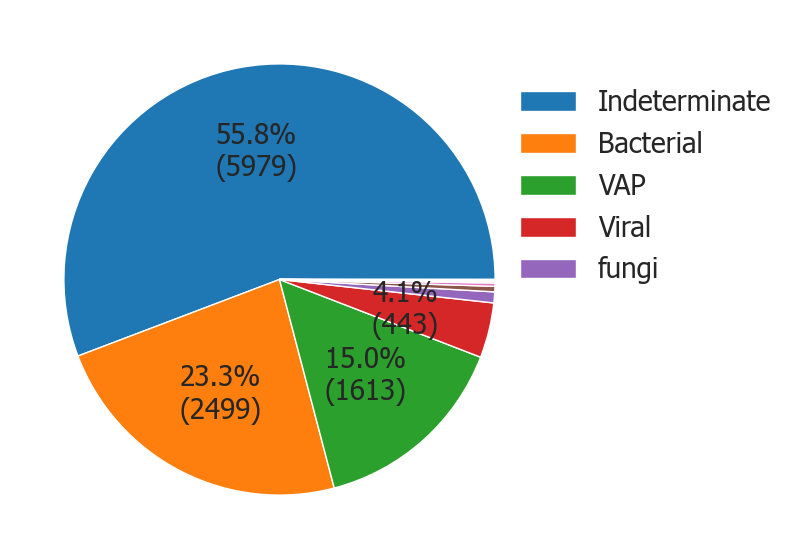

In [34]:
tmp = icd_pneu.cat.value_counts()
fig, ax = plt.subplots(figsize=plots.stdfigsize(nx=1, ny=1))

wedges, texts, autotexts = ax.pie(tmp, labels = tmp.index, autopct=autopct_format(tmp), textprops={'fontsize': 20}, labeldistance=None)

ax.legend(wedges[:5], tmp.index[:5],
          title='',
          loc="best",
          bbox_to_anchor=(0.9, 0.9), 
          frameon=False)

# plt.savefig("../plots/mimiciv/discharge_location_240307.png", dpi=150, transparent=True, bbox_inches='tight')

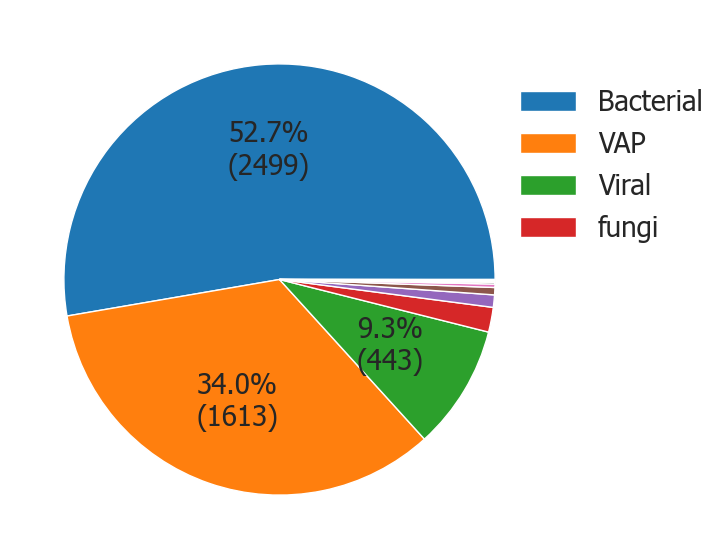

In [35]:
tmp = icd_pneu[icd_pneu!='Indeterminate'].cat.value_counts()
fig, ax = plt.subplots(figsize=plots.stdfigsize(nx=1, ny=1))

wedges, texts, autotexts = ax.pie(tmp, labels = tmp.index, autopct=autopct_format(tmp), textprops={'fontsize': 20}, labeldistance=None)

ax.legend(wedges[:4], tmp.index[:4],
          title='',
          loc="best",
          bbox_to_anchor=(0.9, 0.9), 
          frameon=False)

# plt.savefig("../plots/mimiciv/discharge_location_240307.png", dpi=150, transparent=True, bbox_inches='tight')

In [36]:
mimic = mimic.assign(Patient_category='Other Pneumonia')
mimic.loc[mimic.hadm_id.isin(icd_pneu.loc[icd_pneu.cat=='Indeterminate', 'hadm_id'].values), 'Patient_category'] = 'Indeterminate'
mimic.loc[mimic.hadm_id.isin(icd_pneu.loc[icd_pneu.cat=='Viral', 'hadm_id'].values), 'Patient_category'] = 'Other Viral Pneumonia'
# mimic.loc[mimic.hadm_id.isin(icd_pneu.loc[icd_pneu.cat=='VAP', 'hadm_id'].values), 'Patient_category'] = 'VAP'
# mimic.loc[mimic.hadm_id.isin(icd_pneu.loc[icd_pneu.cat=='Bacterial', 'hadm_id'].values), 'Patient_category'] = 'Bacterial'
# mimic.loc[mimic.hadm_id.isin(icd_pneu.loc[icd_pneu.cat=='fungi', 'hadm_id'].values), 'Patient_category'] = 'Fungal'

In [37]:
carpediem['Dataset'] = 'SCRIPT'
mimic['Dataset'] = 'MIMIC'

In [38]:
# mimic.to_csv(os.path.join(mimic_dir, 'mimic_pat_category.csv'), index=False)

In [39]:
df = pd.concat([carpediem.drop(columns='Patient_id'), mimic.drop(columns='hadm_id')])

In [40]:
cats = ['Discharge', 'Patient_category', 'Gender', 'Race', 'Dataset']
gpby = 'Dataset'

In [41]:
df.reset_index(drop=True, inplace=True)

In [42]:
tmp = TableOne(df, df.columns.to_list(), cats, gpby, pval=True)

/Users/fxx1047/src/clinical_states/.venv/lib/python3.9/site-packages/tableone/tableone.py:927: FutureWarning: The provided callable <function mean at 0x107585c10> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_cont = pd.pivot_table(cont_data,
/Users/fxx1047/src/clinical_states/.venv/lib/python3.9/site-packages/tableone/tableone.py:927: FutureWarning: The provided callable <function median at 0x107a73430> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_cont = pd.pivot_table(cont_data,
/Users/fxx1047/src/clinical_states/.venv/lib/python3.9/site-packages/tableone/tableone.py:927: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided c

In [43]:
# tmp.to_latex('mytable.tex')